# Imports

In [809]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Extracting Data

In [810]:
position = {
    "t": [],
    "x": [],
    "y": [],
    "z": [],
}
 
f = open("Calibration/Cal.a", "r")
headerLen = 10

for l, line in enumerate(f):        
        if l >= headerLen:         
            part = line.split()
            position["t"].append(float(part[0])*0.001)
            position["x"].append(float(part[1])*0.001)
            position["y"].append(float(part[2])*0.001)
            position["z"].append(float(part[3])*0.001)
f.close()

for d in position:
    position[d] = np.array(position[d])
        
df = pd.DataFrame(position)
print(df)

              t       x       y       z
0        0.0287 -0.0045  0.0898  0.0283
1        0.0475 -0.0040  0.0896  0.0282
2        0.0659 -0.0039  0.0894  0.0279
3        0.0839 -0.0040  0.0893  0.0283
4        0.1019 -0.0031  0.0892  0.0277
...         ...     ...     ...     ...
30605  614.4149  0.0051  0.0868  0.0316
30606  614.4341  0.0053  0.0867  0.0321
30607  614.4534  0.0060  0.0864  0.0323
30608  614.4739  0.0053  0.0869  0.0323
30609  614.4942  0.0059  0.0870  0.0327

[30610 rows x 4 columns]


# Plotting x, y and z components as function of time

By plotting the the spatial components as function of time, we can determine which component is vertical, more precisely we can determine which component is the axis of rotation.

NOTE: The axis of rotation will be constant as a function of time

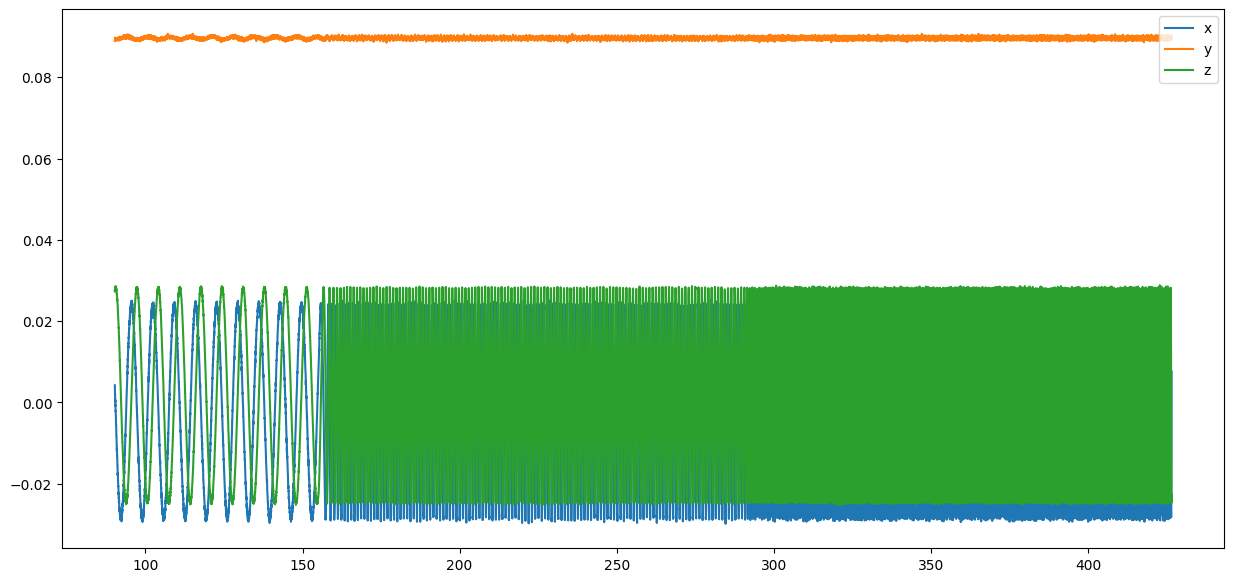

In [811]:
fig, ax = plt.subplots(figsize=(15,7))
for key in df.keys():
    if (key != "t"):
        ax.plot(df["t"][5000:24000], df[key][5000:24000], label = key)

plt.legend(loc = "upper right")
plt.show()

# Selecting regions

We separate the data into regions, where each data region has a constant wavelength.


In [812]:
x1 = df["x"][1530:2000]
t1 = df["t"][1530:2000]
x2 = df["x"][8900:9000]
t2 = df["t"][8900:9000]
x3 = df["x"][16800:16865]
t3 = df["t"][16800:16865]


# Functions

Here we define two functions, one for fitting and the other is the one being fitted.

In [813]:
def f(t, omega, A, alpha):
    return A * np.sin(omega*t + alpha)

def fitting(t, y, omega0, A0, alpha0):
    fig, ax1 = plt.subplots()
    ax1.errorbar(t, y, fmt='+', linewidth=2)
        
    
    p0 = [omega0, A0, alpha0]
    name = ["omega", "A", "alpha"]
    
    
    # ystart = f (t, *p0) 
    # plt . plot (t, ystart , 'g')
    
    # Experimental standard deviation of the mean
    udata = np.zeros(len(y)) + np.std(y)/np.sqrt(len(y))
    
    popt , pcov = curve_fit(f, t, y, p0, sigma=udata , absolute_sigma=True)
    
   
    dymin = (y-f(t, *popt))/udata       
    min_chisq = sum(dymin*dymin)
    dof = len(t)-len(popt)     
    print("Chisquare: " , min_chisq)
    print("Number of degrees of freedom: " , dof )
    print("Chi square per degree of freedom: " , min_chisq/dof)
    print()
    print("Fitted parameters with 68%C.I .:")
    for i,pmin in enumerate(popt):
        print("%2i %-10s %12f +/- %10f"%(i,name[i],pmin,np.sqrt(pcov[i,i])*np.sqrt(min_chisq/dof)))
        
    yfit = f(t,*popt)
    plt.plot(t, yfit, '-r')
    plt.xlabel("time (s)")
    plt.ylabel("x (m)")

# Plotting the fitted functions

Here we display the plots and fit for the different regions.

We also display the parameters obtained from fitting the function.

Chisquare:  2727.0457758125876
Number of degrees of freedom:  467
Chi square per degree of freedom:  5.83949844927749

Fitted parameters with 68%C.I .:
 0 omega          0.915853 +/-   0.001729
 1 A             -0.026278 +/-   0.000135
 2 alpha          4.509838 +/-   0.057086
Chisquare:  178.62702727582288
Number of degrees of freedom:  97
Chi square per degree of freedom:  1.841515745111576

Fitted parameters with 68%C.I .:
 0 omega          5.449136 +/-   0.030131
 1 A             -0.026297 +/-   0.000363
 2 alpha         90.348005 +/-   4.833673
Chisquare:  63.67123706315686
Number of degrees of freedom:  62
Chi square per degree of freedom:  1.02695543650253

Fitted parameters with 68%C.I .:
 0 omega         11.802444 +/-   0.050401
 1 A              0.026041 +/-   0.000410
 2 alpha      -1140.127107 +/-  15.127065


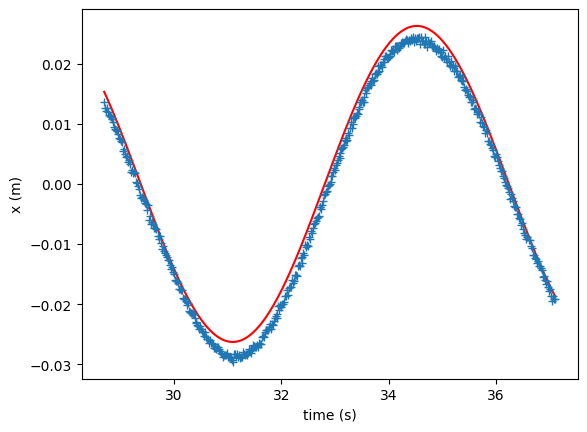

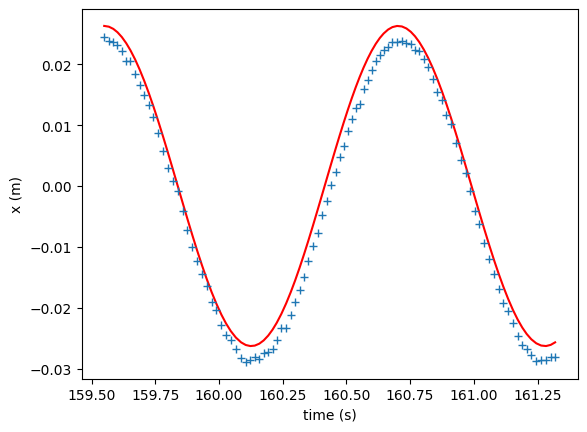

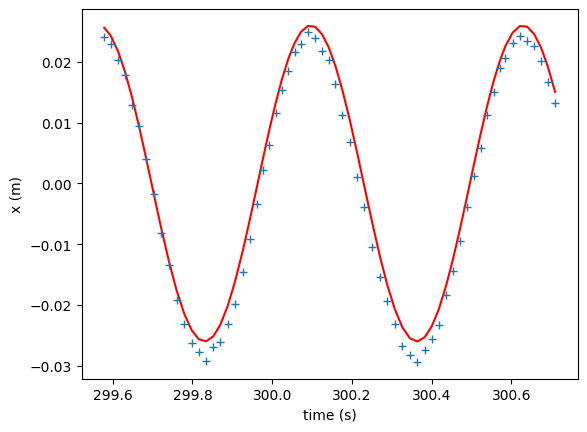

In [814]:
fitting(t1, x1, 1, 25, 1)
fitting(t2, x2, 6, 25, 1)
fitting(t3, x3, 8, 17,0.5)
